In [1]:
import os
os.environ['JAX_PLATFORM_NAME'] = 'cpu' 

### Simple example with one simulated dataset

This first example uses a very simple GPRN structure to fit a single simulated dataset. We will simulate data from a model that, while not being exactly a GPRN, encapsulates much of the same assumptions, making it even easier for the GPRN to match the data. 

First, we import some standard packages and the three main modules from `gpyrn`

In [2]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

from gpyrn import covfunc, meanfunc, meanfield

As you can probably guess, `covfunc` provides covariance functions (kernels) to be used for the GPRN nodes and weights. `meanfunc` provides the mean functions for a given dataset. Note that, in the GPRN model, the nodes and weights are GPs *with mean zero*; the mean functions apply to the output datasets.

Let's simulate some data, using a fixed random seed to guarantee reproducible results

In [3]:
np.random.seed(43)

Our simulation is simple. 
We start by generating 45 *times*, randomly distributed between 10 and 60 (in arbitrary units).
The single output dataset is then created by the multiplication of a sinusoidal function and a quadratic.

The `truth` dictionary stores the true parameters for each function.

In [4]:
truth = {
    'A': 1.5,
    'P': 13.5,
    'Φ': 0.0,
    'c0': 2.5,
    'c1': 0.02,
    'c2': 0.01,
    'j': 0.5,
}

t = np.sort(np.random.uniform(10, 60, 45))

y = truth['A'] * np.sin(2 * np.pi * t / truth['P'] + truth['Φ'])
y *= np.polyval([truth['c2'], truth['c1'], truth['c0']], t)

To simulate individual uncertainties for each point, we draw from a uniform distribution between 2 and 5 (again, in arbitrary units). These are then used, together with a "jitter" value, to add Gaussian noise to the output dataset.

In [5]:
yerr = np.random.uniform(2, 5, size=t.size)
y += norm(0, np.hypot(truth['j'], yerr)).rvs()

Let's plot the data and the components we used to create it

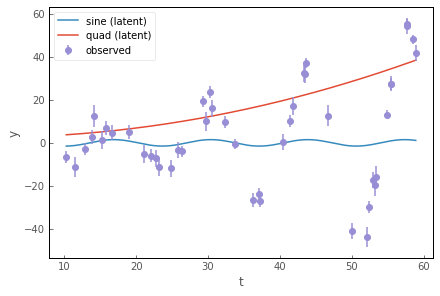

In [6]:
tplot = np.linspace(t[0], t[-1], 1000)
sine = truth['A'] * np.sin(2 * np.pi * tplot / truth['P'] + truth['Φ'])
quad = np.polyval([truth['c2'], truth['c1'], truth['c0']], tplot)


fig, ax = plt.subplots(constrained_layout=True)

ax.plot(tplot, sine, label='sine (latent)')
ax.plot(tplot, quad, label='quad (latent)')
ax.errorbar(t, y, yerr, fmt='o', label='observed')

ax.set(xlabel='t', ylabel='y')
ax.legend();

We now build the GPRN model by specifying its components.

First, we create an `inference` object, passing in the number of nodes we will consider and the simulated data.

In [7]:
gprn = meanfield.inference(1, t, y, yerr)

Next, we define the node and weight kernels.

We use a periodic kernel (also sometimes called exponential sine squared) for the node and a squared exponential for the weight, providing initial values for their hyperparameters. The mean function is just a constant, set initially to 0, while the jitter starts at 0.1.

In [8]:
nodes = covfunc.Periodic(1, 13, 1)
weights = covfunc.SquaredExponential(1, 50)
means = meanfunc.Constant(0)
jitters = 0.1

gprn.set_components(nodes, weights, means, jitters)

We can use the `plot_prediction` method to see what the GPRN prediction looks like with these initial parameters.

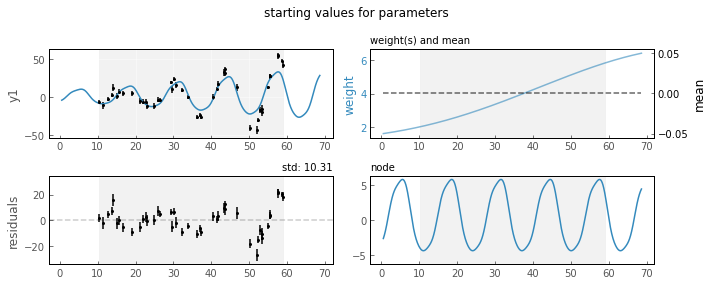

In [9]:
fig, axs = gprn.plot_prediction(title='starting values for parameters')

Let's optimize the parameters, by maximizing the ELBO.

!!! note

    By default, `gpyrn` uses the Nelder-Mead method with `scipy.optimize.minimize`. This can be changed by passing in keyword arguments which go directly into `minimize`.


In [13]:
print('initial ELBO:', gprn.ELBO)
res = gprn.optimize()

initial ELBO: -141.41811491601413


!!! info

    When running the code above you will see the ELBO value changing and information on how much time each iteration of the optimizer took. The value shown above is just the last iteration.

There was quite a large improvement from the initial value for the ELBO.  
Let's see how the parameters of the GPRN components changed

In [14]:
print('node:', gprn.nodes)
print('weight:', gprn.weights)
print('mean:', gprn.means)
print('jitter:', gprn.jitters)

node: [Periodic(theta=19.871606207073505, P=13.628954728975415, ell=5.271329077343856)]
weight: [SquaredExponential(theta=5.136857286672295, ell=39.578213323835314)]
mean: [Constant(-5.677382616050783e-05)]
jitter: [0.00103135]


And now we can plot again the GPRN prediction, together with the actual components we used to generate the data.

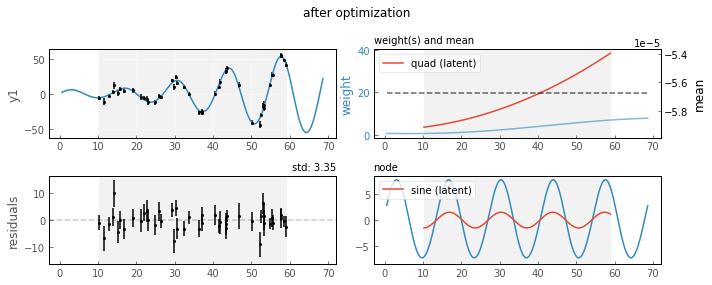

In [15]:
fig, axs = gprn.plot_prediction(title='after optimization')
axs['d1'].plot(tplot, quad, label='quad (latent)')
axs['d1'].legend(loc=2)
axs['node'].plot(tplot, sine, label='sine (latent)')
axs['node'].legend(loc=2);